# Simulating Soybean SC Saga variety

*The input data for simulation is adopted from Alfred Nyambane's thesis report

# Step 1: Importing relevant modules


In [146]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import pcse

from pcse.fileinput import CABOFileReader #Importing CABOFileReader (crop and soil files are saved in CABO format)
from pcse.util import WOFOST80SiteDataProvider
from pcse.fileinput import YAMLCropDataProvider # for crop
from pcse.base import ParameterProvider # combine parameters
from pcse.fileinput import YAMLAgroManagementReader # for agromanagement
from pcse.fileinput import ExcelWeatherDataProvider # for weather
from pcse.models import Wofost72_WLP_FD, Wofost72_PP # import PCSE model

%matplotlib inline


#print("This notebook was built with:")
#print("python version: %s " % sys.version)
#print("PCSE version: %s" %  pcse.__version__)

 # Step 2: Get data

In [147]:
# specify data directory
data_dir = os.path.join(os.getcwd(), "data") 

# Get site data. 
# The following site data can be set through WOFOST72SiteDataProvider. More can be provided through the WOFOST80SiteDataProvider
#- IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#            or not (0). Default 0
#- NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#- SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#- SSI       Initial depth of water stored on the surface [cm]
#- WAV       Initial amount of water in total soil profile [cm]
#- SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
#- CO2       Atmospheric CO2 level (ppm), default 360.

sited = WOFOST80SiteDataProvider(WAV=10, CO2=360)
print(sited)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 10.0, 'SMLIM': 0.4, 'CO2': 360.0, 'BG_N_SUPPLY': 0, 'NSOILBASE': 0, 'NSOILBASE_FR': 0.025, 'BG_P_SUPPLY': 0, 'PSOILBASE': 0, 'PSOILBASE_FR': 0.025, 'BG_K_SUPPLY': 0, 'KSOILBASE': 0, 'KSOILBASE_FR': 0.025}


In [148]:
# Reading crop parameters
cropfile = os.path.join(data_dir, 'crop')
cropd = YAMLCropDataProvider(fpath=cropfile)
#cropd.print_crops_varieties()

#Set crop type and variety
cropd.set_active_crop('soybean', 'Soybean_SC_Saga')

In [22]:
#cropd.print_crops_varieties()
#print(cropd)

The crop profile for SeedCo. SC-Saga soybean cultivar was adopted from the soybean,(original W41) in WOFOST database. This is because Soybean,(original W41) was derived for assessment of tropical region crop production potential by WOFOST developers.

In [149]:
# Reading soil parameters
soilfile = os.path.join(data_dir, 'soil', 'M03.AWC')
soild = CABOFileReader(soilfile)

In [159]:
# Agromanagement
# Potential Production
agromanagement_file = os.path.join(data_dir, 'agro', 'soybean_calendar.agro')
agromanagement = YAMLAgroManagementReader(agromanagement_file)
#print(agromanagement)

# With Irrigation and Fertilizer *still with errors
agromanagement_fileWIF = os.path.join(data_dir, 'agro', 'soybean_calendar_withIrrigationFertilizer.agro')
agromanagementWIF = YAMLAgroManagementReader(agromanagement_fileWIF)
#print(agromanagement)


In [160]:
# Weather data
weatherfile = os.path.join(data_dir, 'meteo', 'Kk1.xls')
weatherd = ExcelWeatherDataProvider(weatherfile)
#print(wdp)

In [152]:
#Combine crop, soil and site data 
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

# Step 3: Build model for simulate water limited and potential production

In [162]:
# Initialize PCSE model
wofsimWLP = Wofost72_WLP_FD(parameters, weatherd, agromanagement) # water limited production
wofsimPP = Wofost72_PP(parameters, weatherd, agromanagement) # potential production


### a. Run model, retrieve and display model output for water limited production

In [54]:
# wofsimWLP.run(days=10) # Run for specified numbe of days
# wofsimWLP.get_variable("LAI") check for values

In [163]:
wofsimWLP.run_till_terminate()
df_resultsWLP = pd.DataFrame(wofsimWLP.get_output())
df_resultsWLP = df_resultsWLP.set_index("day")
#df_resultsWLP.info()
df_resultsWLP.tail() # view last rows 

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2007-07-16,1.435881,9.096746,10823.416397,1231.021645,6775.020479,2817.374273,963.684378,0.282179,120.0,0.224647,26.957648
2007-07-17,1.446829,9.071482,11030.032758,1312.075768,6843.392539,2874.564452,965.466015,0.222233,120.0,0.224548,26.945789
2007-07-18,1.458100,9.017021,11186.986785,1375.194157,6893.698322,2918.094306,966.586689,0.232464,120.0,0.226298,27.155802
2007-07-19,1.468267,8.968556,11357.603684,1445.537798,6946.556291,2965.509595,967.545224,0.180260,120.0,0.228294,27.395237
2007-07-20,1.478710,8.891866,11470.472832,1493.105372,6980.433589,2996.933871,968.024815,0.211297,120.0,0.234737,28.168451


# Step 3: Generate results 

### a) For water limited production

In [164]:
summary_outputWLP = wofsimWLP.get_summary_output()
msg = "Reached maturity at {DOM} with total biomass {TAGP:.1f} kg/ha, " \
      "a yield of {TWSO:.1f} kg/ha with a maximum LAI of {LAIMAX:.2f}."
for crop_cycle in summary_outputWLP:
    print(msg.format(**crop_cycle))

Reached maturity at None with total biomass 11470.5 kg/ha, a yield of 1493.1 kg/ha with a maximum LAI of 9.99.


### Visualize water limited production results 

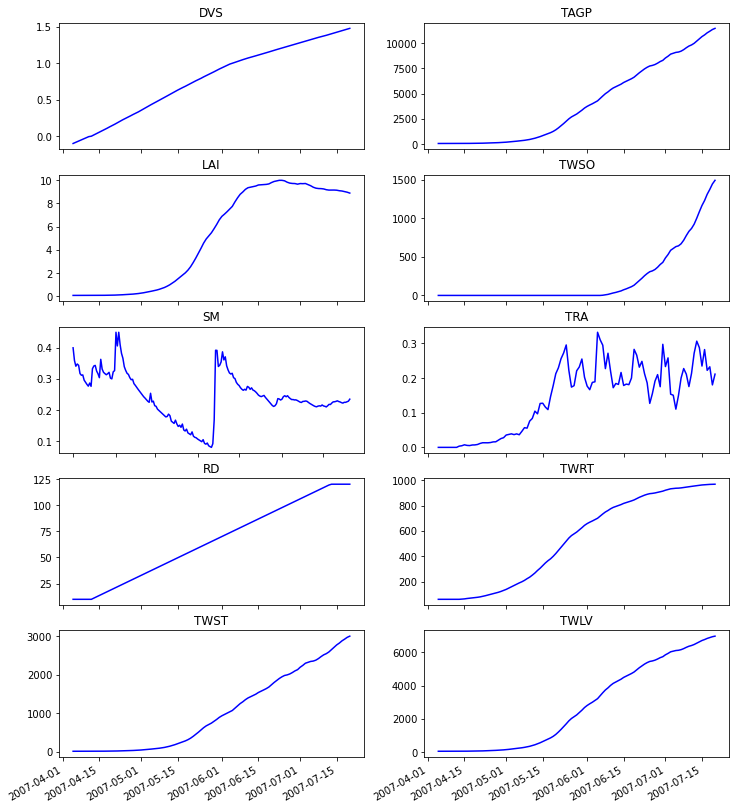

In [167]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,15))
for var, ax in zip(["DVS", "TAGP", "LAI","TWSO", "SM", "TRA", "RD", "TWRT", "TWST", "TWLV"], axes.flatten()):
    ax.plot_date(df_resultsWLP.index, df_resultsWLP[var], 'b-')
    ax.set_title(var)
fig.autofmt_xdate()

In [130]:
# Yield

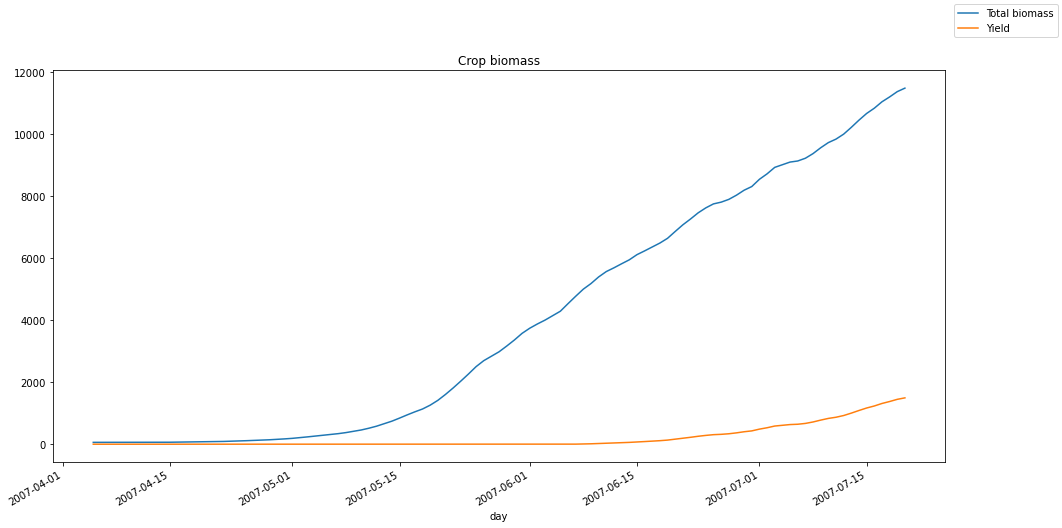

In [158]:
fig, (axis1) = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
df_resultsWLP.TAGP.plot(ax=axis1, label="Total biomass")
df_resultsWLP.TWSO.plot(ax=axis1, label="Yield")
axis1.set_title("Crop biomass")
fig.autofmt_xdate()
r = fig.legend()

# 2. Run model, retrieve and display model output for Potential Production

In [123]:
# wofsimPP.run(days=10) # Run for specified numbe of days
# wofsimPP.get_variable("LAI") check for values
wofsimPP.run_till_terminate()
df_resultsPP = pd.DataFrame(wofsimPP.get_output())
df_resultsPP = df_resultsPP.set_index("day")
#df_resultsWLP.info()
df_resultsPP.tail() # view last rows 

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2007-07-16,1.435881,9.103710,10893.312085,1228.867226,6829.809730,2834.635129,985.818500,0.282204,120.0,0.35,None
2007-07-17,1.446829,9.077939,11099.728022,1309.842724,6898.115467,2891.769832,987.598409,0.222252,120.0,0.35,None
2007-07-18,1.458100,9.022973,11256.475021,1372.877857,6948.354895,2935.242269,988.717605,0.232483,120.0,0.35,None
2007-07-19,1.468267,8.974085,11426.904980,1443.144425,7001.154948,2982.605606,989.675090,0.180273,120.0,0.35,None
2007-07-20,1.478710,8.896999,11539.581005,1490.630609,7034.974282,3013.976114,990.153860,0.211312,120.0,0.35,None


In [124]:
summary_outputPP = wofsimPP.get_summary_output()
msg = "Reached maturity at {DOM} with total biomass {TAGP:.1f} kg/ha, " \
      "a yield of {TWSO:.1f} kg/ha with a maximum LAI of {LAIMAX:.2f}."
for crop_cycle in summary_outputPP:
    print(msg.format(**crop_cycle))

Reached maturity at None with total biomass 11539.6 kg/ha, a yield of 1490.6 kg/ha with a maximum LAI of 10.03.


# Visualize results for potential production

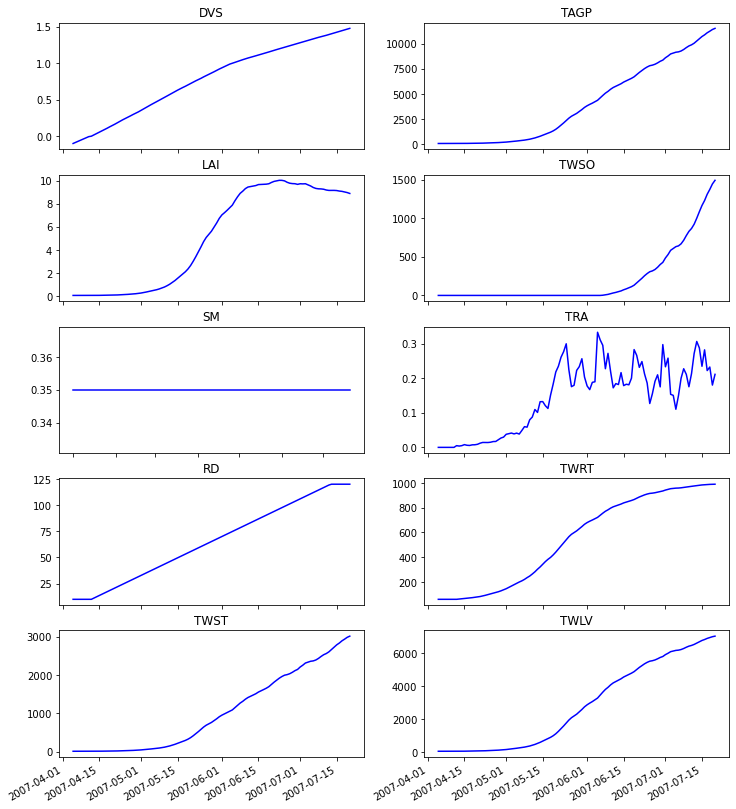

In [168]:
fig2, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,15))
for var, ax in zip(["DVS", "TAGP", "LAI","TWSO", "SM", "TRA", "RD", "TWRT", "TWST", "TWLV"], axes.flatten()):
    ax.plot_date(df_resultsPP.index, df_resultsPP[var], 'b-')
    ax.set_title(var)
fig2.autofmt_xdate()

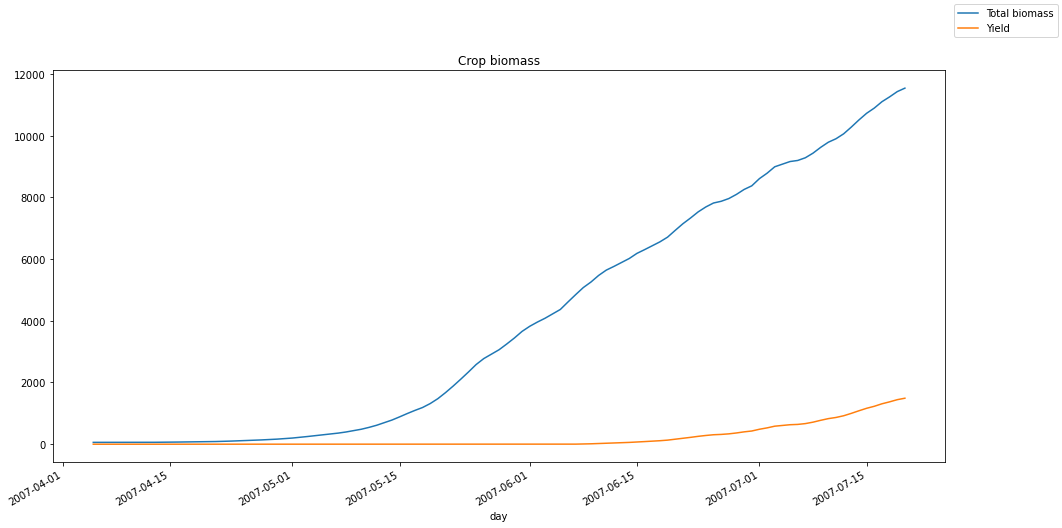

In [169]:
fig, (axis2) = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
df_resultsPP.TAGP.plot(ax=axis2, label="Total biomass")
df_resultsPP.TWSO.plot(ax=axis2, label="Yield")
axis2.set_title("Crop biomass")
fig.autofmt_xdate()
r = fig.legend()